This notebook demonstrates the use of our linear approximation for sensitivity with respect to the Dirichlet process $\alpha$ parameter

In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


# Load data

We load and plot the iris dataset

In [2]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

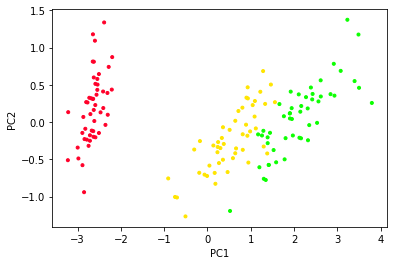

In [3]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Set up model

### Prior parameters

In [4]:
# Get priors
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.5])
print(prior_params_dict)

{'alpha': array([3.5]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


### Variational parameters

In [5]:
# number of clusters in variational distribution 
k_approx = 30

In [6]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [7]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [8]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1747.195163331245

# Optimize the KL objective

### Initialize with k-means

In [9]:
# run a kmeans init
n_kmeans_init = 50
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 920)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
8767.599899567294


In [10]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

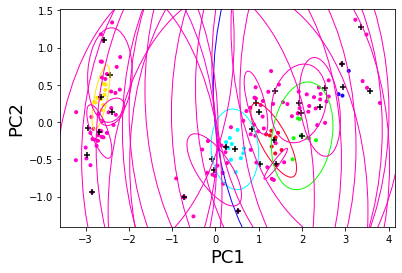

In [11]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [12]:
vb_params_dict = deepcopy(init_vb_params_dict)

## optimize

In [13]:
run_newton = True

In [14]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

get_loss = lambda x : get_vb_params_loss(features, x, prior_params_dict, gh_loc, gh_weights)


In [15]:
if run_newton: 
    vb_opt = optimization_lib.optimize_full(get_loss, deepcopy(init_vb_free_params),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
    e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)
    
else: 
    vb_opt_dict, e_z_opt, kl_loss = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                           debug = False)
    vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

    plt.plot(kl_loss, '-x')

running bfgs ... 
Iter 0: f = 8767.59989957
Iter 1: f = 6150.01631289
Iter 2: f = 4521.33010845
Iter 3: f = 3248.21108713
Iter 4: f = 2450.93977229
Iter 5: f = 2254.19983831
Iter 6: f = 2009.48247070
Iter 7: f = 1753.62247316
Iter 8: f = 1791.58618712
Iter 9: f = 1614.43924690
Iter 10: f = 1515.29387260
Iter 11: f = 1401.07681569
Iter 12: f = 1323.89391430
Iter 13: f = 1221.66343542
Iter 14: f = 1121.64812390
Iter 15: f = 1033.33890667
Iter 16: f = 911.61739357
Iter 17: f = 915.26501203
Iter 18: f = 848.24352036
Iter 19: f = 743.31544146
Iter 20: f = 670.97212246
Iter 21: f = 573.85812326
Iter 22: f = 465.52884213
Iter 23: f = 390.08422857
Iter 24: f = 287.58168158
Iter 25: f = 190.33330552
Iter 26: f = 129.96681506
Iter 27: f = 93.80645599
Iter 28: f = 40.01810202
Iter 29: f = -14.79284281
Iter 30: f = -85.24396002
Iter 31: f = -137.25834140
Iter 32: f = -127.25269998
Iter 33: f = -161.38193141
Iter 34: f = -185.59819467
Iter 35: f = -213.80126623
Iter 36: f = -247.40573778
Iter 37: f

Iter 297: f = -365.58029522
Iter 298: f = -365.67524705
Iter 299: f = -365.84704050
Iter 300: f = -366.12254965
Iter 301: f = -366.48803412
Iter 302: f = -366.90270657
Iter 303: f = -366.18003651
Iter 304: f = -367.02456204
Iter 305: f = -367.16930281
Iter 306: f = -367.36842465
Iter 307: f = -367.52507930
Iter 308: f = -367.70637300
Iter 309: f = -367.83558217
Iter 310: f = -367.92301454
Iter 311: f = -368.01012914
Iter 312: f = -367.99829067
Iter 313: f = -368.05111464
Iter 314: f = -368.07972494
Iter 315: f = -368.03598146
Iter 316: f = -368.08798115
Iter 317: f = -368.09793209
Iter 318: f = -368.09620578
Iter 319: f = -368.10053193
Iter 320: f = -368.10264493
Iter 321: f = -368.09850620
Iter 322: f = -368.10292557
Iter 323: f = -368.10337260
Iter 324: f = -368.10353397
Iter 325: f = -368.10377754
Iter 326: f = -368.10352918
Iter 327: f = -368.10382767
Iter 328: f = -368.10389676
Iter 329: f = -368.10385932
Iter 330: f = -368.10391046
Iter 331: f = -368.10392617
Iter 332: f = -368.1

In [16]:
continue_with_newton = False

if continue_with_newton: 
    
    vb_opt2 = optimization_lib.optimize_full(get_loss, 
                    deepcopy(vb_opt),
                    bfgs_max_iter = 500, netwon_max_iter = 50,
                    max_precondition_iter = 10,
                    gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
    print('\nlinf diff in vb_params: ', np.abs(vb_opt2 - vb_opt).max())
    
    vb_opt = deepcopy(vb_opt2)
    pt_dict = vb_params_paragami.fold(vb_opt, free = True)
    e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_opt_dict, gh_loc, gh_weights)
    

### Check optimum

In [17]:
get_prior_vb_loss = paragami.FlattenFunctionInput(original_fun=gmm_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: get_prior_vb_loss(features, x, y, gh_loc, gh_weights)

In [18]:
# get hessian 
t0 = time.time()
get_hess = autograd.hessian(objective_fun, argnum = 0)
hess = get_hess(vb_opt, prior_params_paragami.flatten(prior_params_dict, free = True))
print('hessian time: {}sec'.format(np.round(time.time() - t0, 3)))

hess_solver = vittles.solver_lib.get_cholesky_solver(hess)

hessian time: 14.272sec


In [19]:
# gradient 
get_objective_grad = autograd.jacobian(objective_fun, argnum = 0)

In [20]:
optimum_checker = vittles.bivariate_sensitivity_lib.OptimumChecker(
                                                estimating_equation = get_objective_grad, 
                                                solver = hess_solver, 
                                                input_base = vb_opt, 
                                                hyper_base = prior_params_paragami.flatten(prior_params_dict, 
                                                                                           free = True))

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/vittles/bivariate_sensitivity_lib.py:32: UserWarning: The CrossSensitivity class is very experimental and untested.
  warnings.warn(


In [21]:
prior_pert = prior_params_paragami.flatten(deepcopy(prior_params_dict), free = True)
prior_pert[0] = prior_pert[0] + 1

dhyper = prior_pert - prior_params_paragami.flatten(prior_params_dict, free = True)

In [22]:
get_objective_grad(vb_opt, prior_params_paragami.flatten(prior_params_dict, 
                                                        free = True))

array([-1.14408057e-08,  1.11851078e-08, -1.74086428e-08,  4.17967969e-09,
       -5.57894809e-07,  9.63353726e-08, -2.00440308e-08,  5.94007107e-09,
       -9.29716534e-09,  1.27052936e-09, -1.96858502e-08, -1.05327962e-08,
       -3.19049769e-10, -9.64534859e-09,  4.34572967e-08, -1.96373244e-09,
       -7.22381873e-09, -1.70842101e-08, -4.04268067e-09,  2.41053818e-08,
        4.82729469e-09, -6.22671472e-10, -7.98507047e-09, -1.07717281e-09,
       -9.40728884e-09,  1.59509735e-08,  8.17245138e-09,  2.49696262e-09,
       -2.80607931e-09, -1.77465751e-08, -2.62275597e-08, -9.55096536e-08,
        1.31407977e-08, -1.08134637e-08,  5.14109295e-07, -8.51013589e-07,
        7.04565331e-08, -4.53464133e-09, -5.34807498e-09,  3.44364855e-09,
        7.28751275e-09, -3.19900205e-08,  1.80756645e-09,  2.05028622e-08,
       -2.91487048e-08, -3.18075125e-08, -5.12157252e-09,  1.32855998e-08,
        1.33061384e-08, -3.38894620e-09,  8.03999660e-10, -7.52229770e-10,
       -3.37969304e-09, -

In [23]:
optimum_checker._lam_base

array([ 1.14408057e-08, -1.11851078e-08,  1.74086428e-08, -4.17967969e-09,
        5.57894809e-07, -9.63353726e-08,  2.00440308e-08, -5.94007107e-09,
        9.29716534e-09, -1.27052936e-09,  1.96858502e-08,  1.05327962e-08,
        3.19049769e-10,  9.64534859e-09, -4.34572967e-08,  1.96373244e-09,
        7.22381873e-09,  1.70842101e-08,  4.04268067e-09, -2.41053818e-08,
       -4.82729469e-09,  6.22671472e-10,  7.98507047e-09,  1.07717281e-09,
        9.40728884e-09, -1.59509735e-08, -8.17245138e-09, -2.49696262e-09,
        2.80607931e-09,  1.77465751e-08,  2.62275597e-08,  9.55096536e-08,
       -1.31407977e-08,  1.08134637e-08, -5.14109295e-07,  8.51013589e-07,
       -7.04565331e-08,  4.53464133e-09,  5.34807498e-09, -3.44364855e-09,
       -7.28751275e-09,  3.19900205e-08, -1.80756645e-09, -2.05028622e-08,
        2.91487048e-08,  3.18075125e-08,  5.12157252e-09, -1.32855998e-08,
       -1.33061384e-08,  3.38894620e-09, -8.03999660e-10,  7.52229770e-10,
        3.37969304e-09,  

In [24]:
optimum_checker.correction(dhyper)

array([ 7.87875402e-09, -6.82585036e-10,  1.39561192e-08, -5.05715235e-09,
        5.50096991e-10,  3.42611583e-10,  1.25701644e-08, -9.73369631e-09,
        1.02835125e-08, -1.41538653e-09,  1.81225810e-08,  9.71795008e-09,
        4.31180399e-10,  8.61868662e-09, -3.97890073e-08,  1.78320724e-09,
        6.63251275e-09,  1.56784106e-08,  3.69353127e-09, -2.22201867e-08,
       -4.44529428e-09,  5.64861538e-10,  7.35932186e-09,  9.86360872e-10,
        8.65860019e-09, -1.46990313e-08, -7.52764930e-09, -2.29997930e-09,
        2.58371403e-09,  1.63333341e-08,  1.58829707e-08,  9.62965619e-08,
       -1.63811524e-08,  8.03312199e-09,  5.44431920e-11,  9.66764617e-10,
       -7.02903463e-08, -3.08903885e-09,  8.05586585e-09, -3.28727026e-09,
       -6.23705310e-09,  2.90574632e-08, -1.67431041e-09, -1.89025111e-08,
        2.68268448e-08,  2.91519343e-08,  4.69033705e-09, -1.21989285e-08,
       -1.22509635e-08,  3.09811840e-09, -7.45626177e-10,  6.78530488e-10,
        3.09584230e-09,  

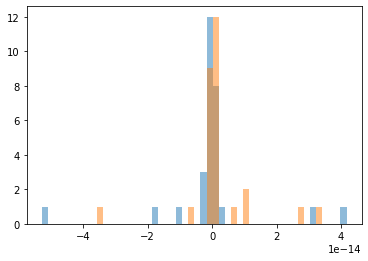

In [24]:
bins = plt.hist(newton_step[utils_lib.get_param_indices('stick_propn_mean', vb_params_dict, vb_params_paragami)],
         alpha = 0.5, bins = 50)
plt.hist(newton_step[utils_lib.get_param_indices('stick_propn_info', vb_params_dict, vb_params_paragami)],
         alpha = 0.5, bins=bins[1]);

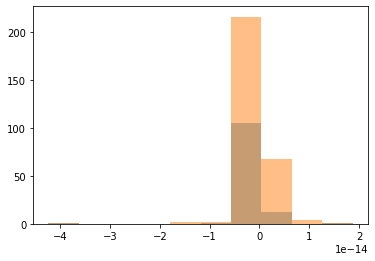

In [25]:
bins= plt.hist(newton_step[utils_lib.get_param_indices('centroids', vb_params_dict, vb_params_paragami)],
         alpha = 0.5)
plt.hist(newton_step[utils_lib.get_param_indices('cluster_info', vb_params_dict, vb_params_paragami)],
         alpha = 0.5, bins=bins[1]);



### Check results

Text(0, 0.5, 'PC2')

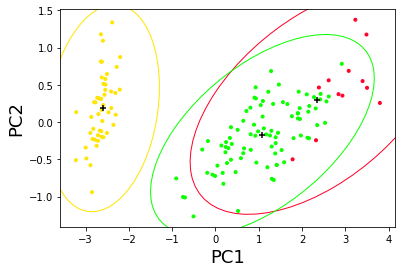

In [26]:
# optimization results
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Parametric sensitivity

### Get the hyper parameter sensitivity object

In [27]:
vb_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = objective_fun, 
        opt_par_value = vb_opt, 
        hyper_par_value = prior_params_paragami.flatten(prior_params_dict, free=True), 
        hessian_at_opt = hess)


### Set new prior

In [28]:
new_alpha = np.array([5.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['alpha'] = new_alpha


In [29]:
print('initial alpha, ', prior_params_dict['alpha'])
print('perturbed alpha, ', prior_params_pert_dict['alpha'])

initial alpha,  [3.5]
perturbed alpha,  [5.]


### get linear response prediction

In [30]:
lr_vb_free_params = \
    vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True))

In [31]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))

l_inf diff:  0.4121565461629424


### re-optimize

In [32]:
new_init_dict = deepcopy(vb_opt_dict)
# new_init_dict = deepcopy(init_vb_params_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [33]:
run_newton = False

In [34]:
if run_newton :
    # set up new objective, with the prior changed
    get_pert_loss = lambda x : get_vb_params_loss(features, x, prior_params_pert_dict, gh_loc, gh_weights)

    # Run newton
    vb_opt_pert = optimization_lib.optimize_full(get_pert_loss, deepcopy(new_init_free),
                        bfgs_max_iter = 500, netwon_max_iter = 50,
                        max_precondition_iter = 10,
                        gtol=1e-8, ftol=1e-8, xtol=1e-8)
    
else: 
    vb_pert_dict, e_z_pert, kl_loss = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                            vb_params_paragami, prior_params_pert_dict,
                                            gh_loc, gh_weights,
                                           debug = True)
    
    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

stick_time: 0.573sec
cluster_time: 0.201sec
e_z_time: 0.091sec
**TOTAL time: 1.465sec**


### Compare linear response with refitting

In [35]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

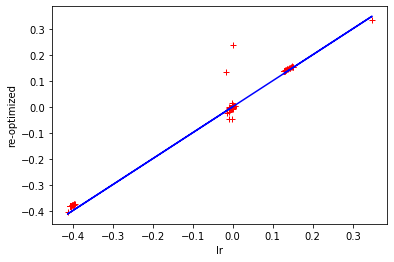

In [36]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [37]:
get_loss(lr_vb_free_params)

-361.8620893524095

In [38]:
get_loss(vb_opt_pert)

-361.9533747998699

# Fit for a range of alpha 

In [39]:
alpha_list = np.arange(1, 15)

In [40]:
def refit_with_alpha(alpha, vb_opt, new_init_dict, run_newton):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    if run_newton:
                
        # set up new objective, with the prior changed
        get_pert_loss = lambda x : get_vb_params_loss(features, x, prior_params_pert_dict, gh_loc, gh_weights)

        # Run newton
        vb_opt_pert = optimization_lib.optimize_full(get_pert_loss, 
                            vb_params_paragami.flatten(deepcopy(new_init_dict), free = True),
                            bfgs_max_iter = 500, netwon_max_iter = 50,
                            max_precondition_iter = 10,
                            gtol=1e-8, ftol=1e-8, xtol=1e-8)

    else: 
        vb_pert_dict, e_z_pert, kl_loss = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                                vb_params_paragami, prior_params_pert_dict,
                                                gh_loc, gh_weights,
                                               debug = True)

        vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert

### Re-optimize for range of alphas

In [41]:
print('alphas: ', alpha_list)

alphas:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [42]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\nre-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, vb_opt, new_init_dict, run_newton))


re-optimzing with alpha =  1
stick_time: 0.549sec
cluster_time: 0.205sec
e_z_time: 0.095sec
**TOTAL time: 1.468sec**

re-optimzing with alpha =  2
stick_time: 0.531sec
cluster_time: 0.196sec
e_z_time: 0.089sec
**TOTAL time: 1.417sec**

re-optimzing with alpha =  3
stick_time: 0.564sec
cluster_time: 0.215sec
e_z_time: 0.098sec
**TOTAL time: 1.517sec**

re-optimzing with alpha =  4
stick_time: 0.575sec
cluster_time: 0.209sec
e_z_time: 0.091sec
**TOTAL time: 1.495sec**

re-optimzing with alpha =  5
stick_time: 0.56sec
cluster_time: 0.214sec
e_z_time: 0.097sec
**TOTAL time: 1.513sec**

re-optimzing with alpha =  6
stick_time: 0.548sec
cluster_time: 0.203sec
e_z_time: 0.093sec
**TOTAL time: 1.468sec**

re-optimzing with alpha =  7
stick_time: 0.584sec
cluster_time: 0.228sec
e_z_time: 0.101sec
**TOTAL time: 1.589sec**

re-optimzing with alpha =  8
stick_time: 0.597sec
cluster_time: 0.234sec
e_z_time: 0.1sec
**TOTAL time: 1.612sec**

re-optimzing with alpha =  9
stick_time: 0.525sec
cluster_

### get linear response prediction for each alpha

In [68]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['alpha'] = new_alpha
    
    # get linear response
    lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True)))
    

In [69]:
optimum_checker._dlam

array([ 1.61398672e-14,  5.60662627e-15,  4.74620343e-15,  3.59434704e-15,
       -4.31432667e-13, -2.36033415e-12, -3.59434704e-15, -1.51212376e-13,
        1.74860126e-15,  2.28983499e-15,  1.25593980e-15,  1.04777298e-15,
        7.97972799e-16,  5.03069808e-16,  4.02455846e-16, -4.85722573e-17,
        3.79904441e-16,  1.51788304e-16,  2.57172755e-16,  1.66099773e-16,
        5.85469173e-17,  5.83300769e-17,  4.25007252e-17,  4.42354486e-17,
        2.05998413e-17,  3.23634348e-17,  9.37834879e-18,  1.76182853e-17,
        1.03270257e-17,  4.41270284e-17, -5.32907052e-15, -1.66533454e-16,
       -9.43689571e-16, -3.88578059e-16,  7.68496378e-13, -4.27569091e-12,
        3.33066907e-15,  2.40696352e-13,  3.21964677e-15,  2.74780199e-15,
        1.05471187e-15,  2.49800181e-16,  9.57567359e-16,  5.06539255e-16,
        6.27969898e-16,  4.44089210e-16,  2.74086309e-16,  1.17961196e-16,
        7.11236625e-17,  1.32706346e-16,  1.46584134e-16,  6.50521303e-17,
        4.81385765e-17, -

In [70]:
optimum_checker.correction(prior_params_paragami.flatten(prior_params_pert_dict, free = True))

ValueError: JVP is only supported for 2d input.

In [53]:
### Get Newton step correction to linear response
lr_list_corr = []
for i in range(len(lr_list)): 
    correction = optimum_checker.correction(prior_params_paragami.flatten(
                                                        prior_params_pert_dict, free = True))
    lr_list_corr.append(lr_list[i] + newton_step + correction)
                        

ValueError: JVP is only supported for 2d input.

### examine results 

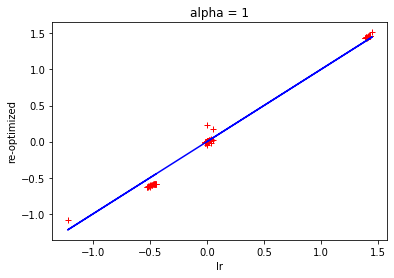

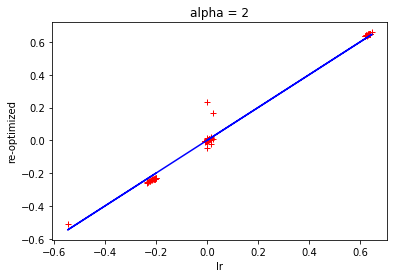

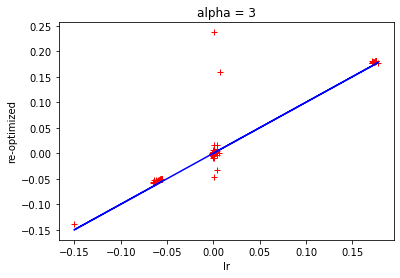

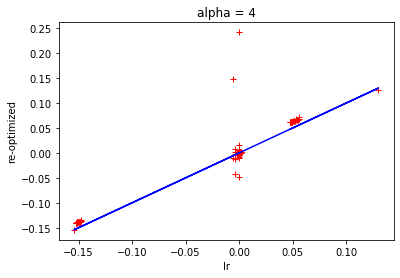

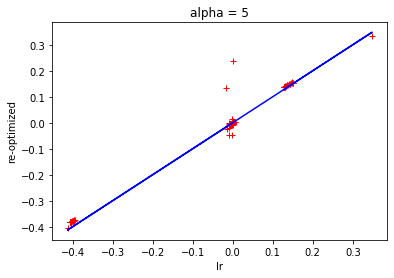

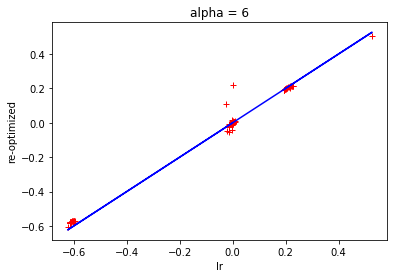

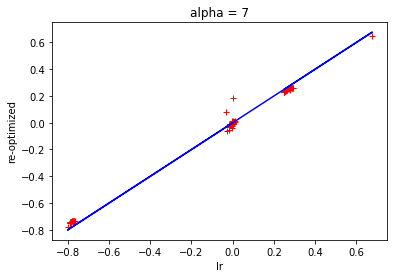

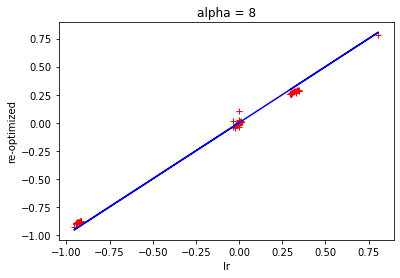

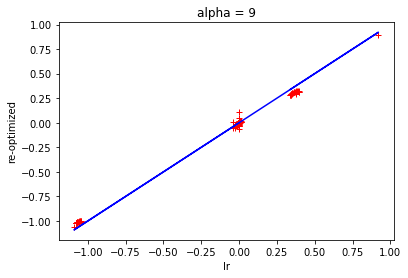

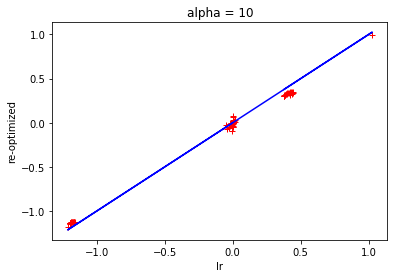

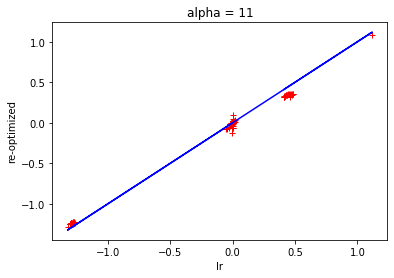

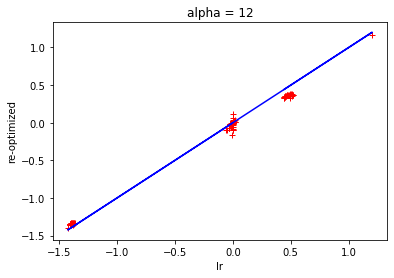

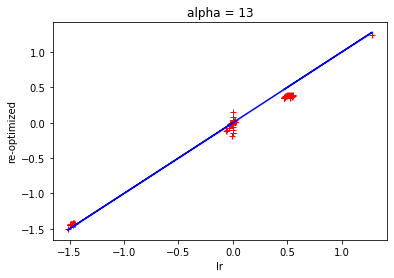

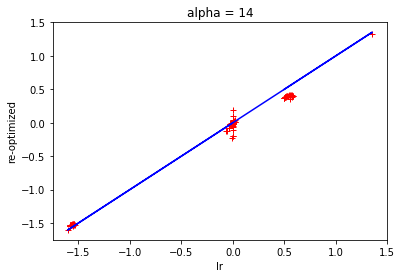

In [46]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))
    
#     opt_dict = vb_params_paragami.fold(vb_opt, free = True)
#     lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
#     pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    
# #     print_diff_plot(vb_params_paragami['stick_params'].flatten(lr_dict['stick_params'], free = True), 
# #                     vb_params_paragami['stick_params'].flatten(pert_dict['stick_params'], free = True), 
# #                     vb_params_paragami['stick_params'].flatten(opt_dict['stick_params'], free = True))
    
#     print_diff_plot(vb_params_paragami['cluster_params'].flatten(lr_dict['cluster_params'], free = True), 
#                 vb_params_paragami['cluster_params'].flatten(pert_dict['cluster_params'], free = True), 
#                 vb_params_paragami['cluster_params'].flatten(opt_dict['cluster_params'], free = True))



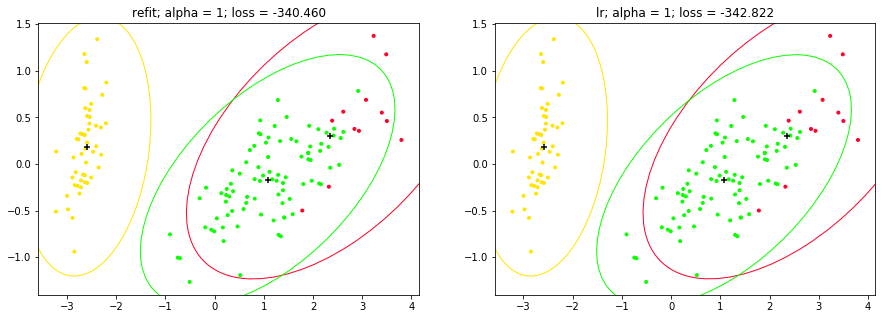

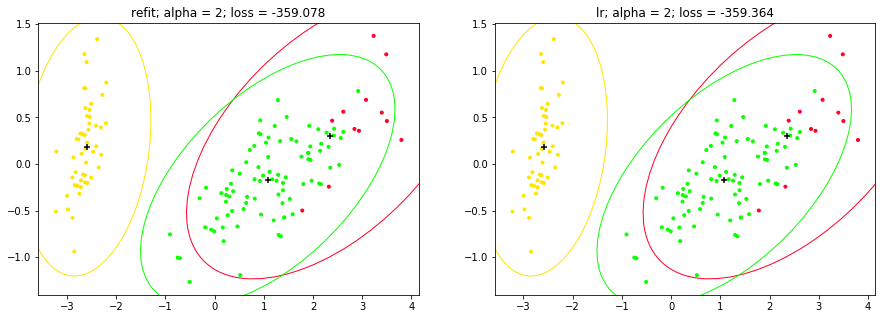

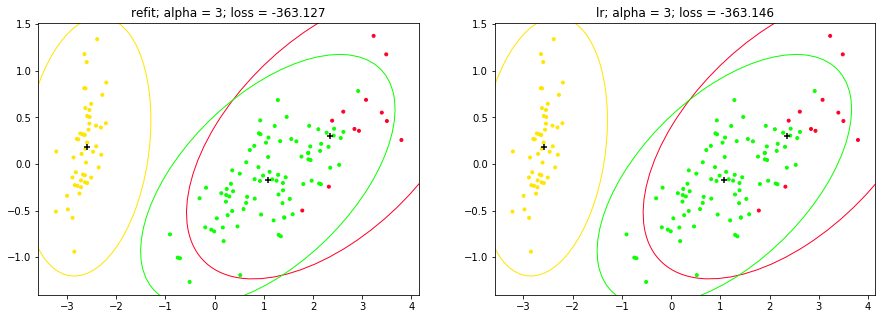

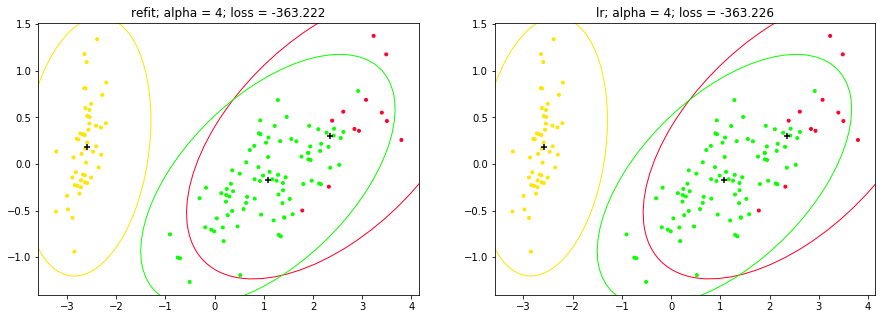

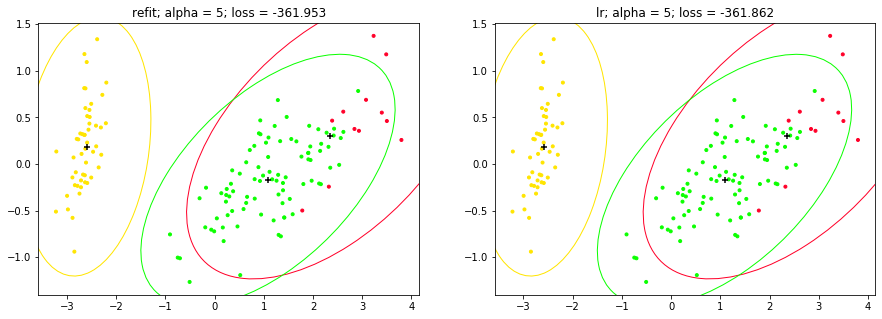

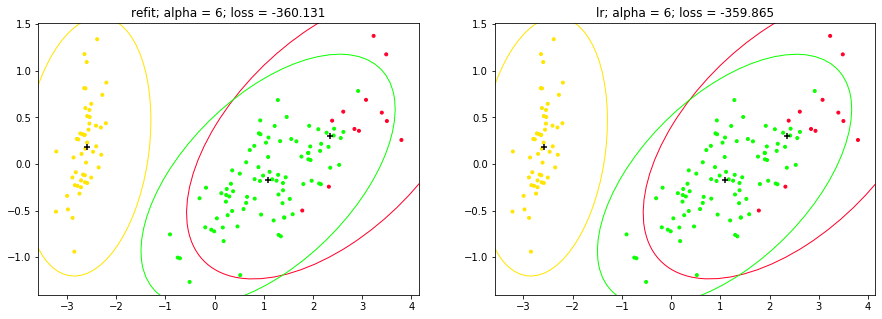

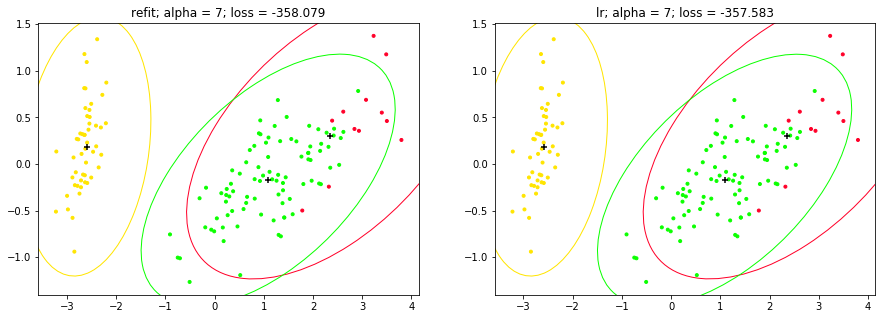

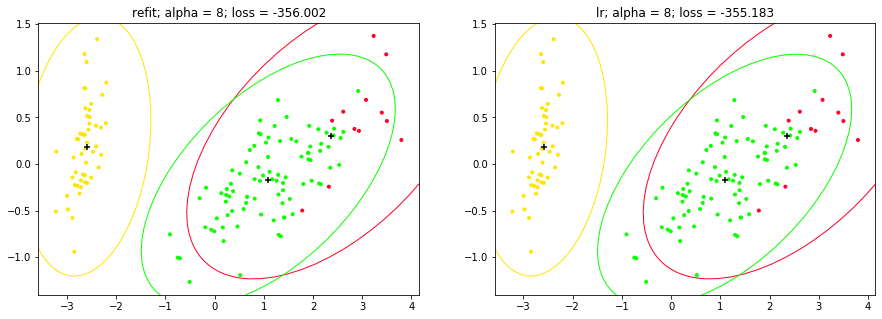

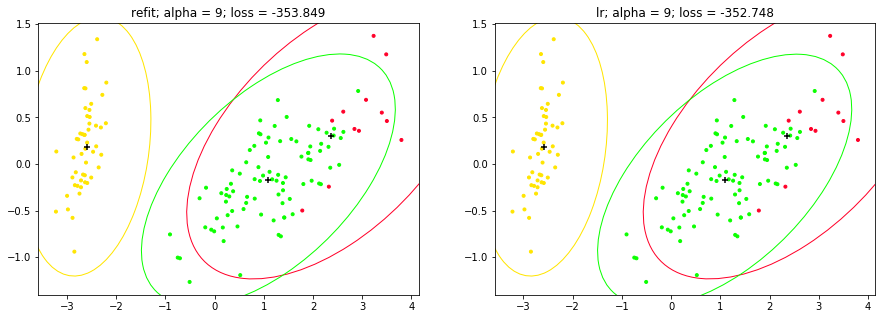

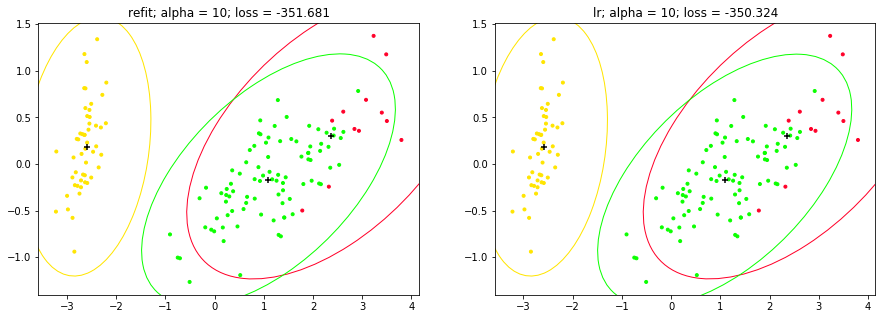

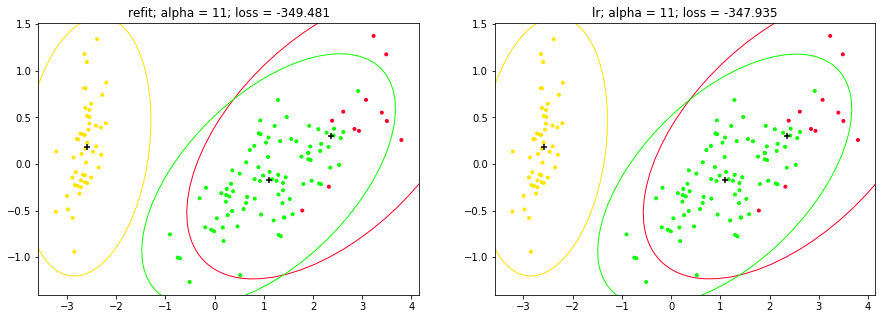

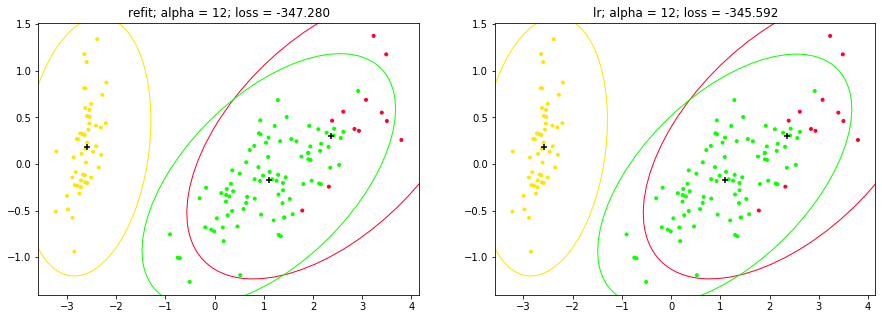

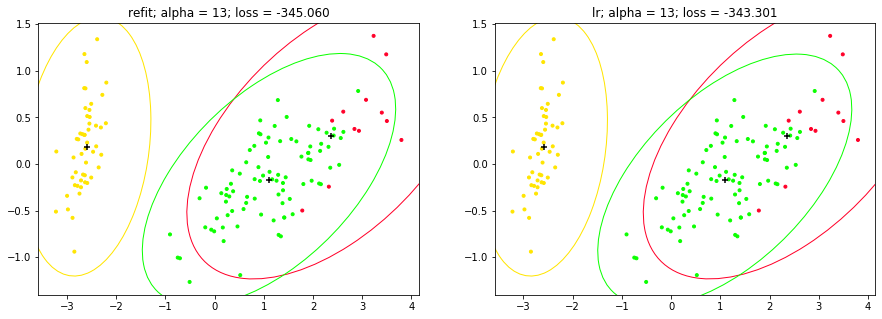

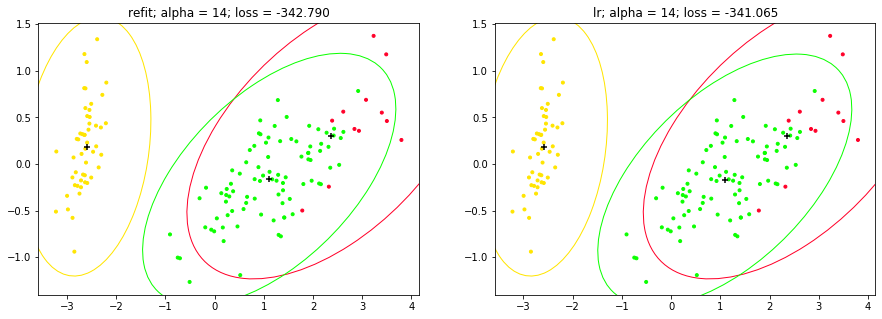

In [47]:
for i in range(len(alpha_list)): 

    fig, axes = plt.subplots(1, 2, figsize = (15, 5))

    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)

    plot_results_from_vb_params_dict(pca_fit, pert_dict, 
                                     gmm_lib.get_optimal_z_from_vb_params_dict(features, pert_dict,
                                                                                gh_loc, gh_weights), 
                                     axes[0])
    
    plot_results_from_vb_params_dict(pca_fit, lr_dict, 
                                     gmm_lib.get_optimal_z_from_vb_params_dict(features, lr_dict,
                                                                                gh_loc, gh_weights), 
                                     axes[1])
    
    axes[0].set_title('refit; alpha = {}; loss = {:.03f}'.format(alpha_list[i], get_loss(vb_pert_list[i])))
    axes[1].set_title('lr; alpha = {}; loss = {:.03f}'.format(alpha_list[i], get_loss(lr_list[i])))

# Check results on number of clusters

### results on number of in-sample clusters

In [48]:
threshold = 0

lr_e_num_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    # number of clusters as predicted by linear response
    lr_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    lr_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_clusters_vec[i] = lr_e_num_clusters
    
    # number of clusters after refitting 
    refit_e_num_clusters, _ = gmm_lib.get_e_num_clusters_from_free_par(features, vb_params_paragami, 
                                    vb_pert_list[i],
                                    gh_loc, gh_weights,
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_clusters_vec[i] = refit_e_num_clusters
    


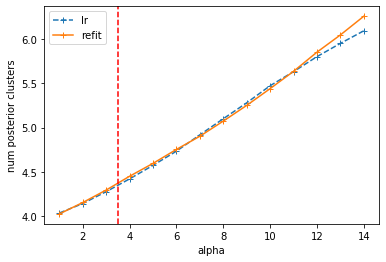

In [49]:
plt.plot(alpha_list, lr_e_num_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')


### Results on posterior predictive clusters

In [50]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(alpha_list))
refit_e_num_pred_clusters_vec = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    lr_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(vb_params_paragami, 
                                    vb_pert_list[i],
                                    n_obs = np.shape(features)[0], 
                                    threshold = threshold,
                                    n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


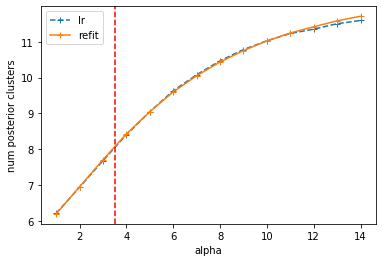

In [51]:
plt.plot(alpha_list, lr_e_num_pred_clusters_vec, '+--')
plt.plot(alpha_list, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))

plt.axvline(prior_params_dict['alpha'], color = 'red', linestyle = 'dashed')
